# Inverted emissions

In [1]:
import warnings
import numpy as np
import pandas as pd
import openpyxl
from scipy.interpolate import make_smoothing_spline, interp1d
from scipy.integrate import solve_ivp
import h5py
from tables import NaturalNameWarning
from mce.util.io import RetrieveGitHub
from mce.core.forcing import RfAll
from mce.util.plot_base import PlotBase

In [2]:
warnings.simplefilter('ignore', NaturalNameWarning)

In [3]:
forcing = RfAll()
myplt = PlotBase(palette='ipcc_wg1')

In [4]:
outpath = 'untracked/datain_2024.h5'

## Input data

In [5]:
# GHG concentrations stored with mk_forcing_ar6.ipynb
with pd.HDFStore(outpath, mode='r') as store:
    dname = 'ClimateIndicator-2024/forcing-timeseries'
    df_conc_ghg = store[f'{dname}/conc_ghg']

In [6]:
# CH4 and N2O emissions from Climate Indicator
repo = RetrieveGitHub('ClimateIndicator', 'GHG-Emissions-Assessment', 'datain')

path = repo.retrieve('results/ghg_emissions_co2e_2024.xlsx')
wb = openpyxl.load_workbook(path, read_only=True, data_only=True)

rows = wb['data_original_units'].iter_rows(
    max_col=5, max_row=1159, values_only=True,
)
columns = next(rows)
df = pd.DataFrame(list(rows), columns=columns)
dfin = (
    df
    .set_index(['label', 'source', 'units', 'year'])
    .squeeze()
    .unstack('year').T
    .rename(int)
    .rename_axis(None)
)

wb.close()

[2024-12-09 16:54:17 mce.util.io] INFO:Use local file datain/ClimateIndicator/GHG-Emissions-Assessment/results/ghg_emissions_co2e_2024.xlsx retrieved from https://github.com/ClimateIndicator/GHG-Emissions-Assessment/raw/main/results/ghg_emissions_co2e_2024.xlsx on 2024-10-11


In [7]:
dfin

label         CH4                      CO2-FFI        N2O                  
source GFED v4.1* PRIMAP CR v2.5.1* GCB v2023* GFED v4.1* PRIMAP CR v2.5.1*
units       MtCH4             MtCH4      GtCO2      MtN2O             MtN2O
1750       11.317              26.9        NaN      0.763             0.121
1751       11.103              27.0        NaN      0.751             0.123
1752       10.994              27.1        NaN      0.747             0.124
1753       11.087              27.1        NaN      0.748             0.125
1754       11.361              27.2        NaN      0.766             0.126
...           ...               ...        ...        ...               ...
2019       17.840             305.0  36.327923      0.997            10.300
2020       12.700             303.0  34.274739      0.859            10.400
2021       15.580             307.0  36.049642      1.058            10.500
2022       10.320             312.0  36.379452      0.706            10.600
2023       22.170               NaN        NaN      1.376               NaN

[274 rows x 5 columns]

In [8]:
# Drop CO2
dfin = dfin.drop('CO2-FFI', axis=1)

In [9]:
# Tentative update for 2023 with PRIMAP v2.6 based on changes from 2022
# csv data were downloaded at
# https://primap.org/primap-hist/#scenario=histcr&id=earth&entity=ch4
# and
# https://primap.org/primap-hist/#scenario=histcr&id=earth&entity=n2o
df = pd.DataFrame({
    gas:
    pd.read_csv(f'datain/PRIMAP/v2.6/HISTCR_EARTH_{gas}_Mt.csv', index_col=0)
    .sum(axis=1)
    for gas in ['CH4', 'N2O']
}).rename_axis(None)

d1 = df.loc[2023] - df.loc[2022]

for gas in ['CH4', 'N2O']:
    unit = f'Mt{gas}'
    dfin.loc[2023, (gas, 'PRIMAP CR v2.5.1*', unit)] = (
        dfin.loc[2022, (gas, 'PRIMAP CR v2.5.1*', unit)]
        + d1[gas]
    )

In [10]:
dfin

label         CH4                          N2O                  
source GFED v4.1* PRIMAP CR v2.5.1* GFED v4.1* PRIMAP CR v2.5.1*
units       MtCH4             MtCH4      MtN2O             MtN2O
1750       11.317            26.900      0.763             0.121
1751       11.103            27.000      0.751             0.123
1752       10.994            27.100      0.747             0.124
1753       11.087            27.100      0.748             0.125
1754       11.361            27.200      0.766             0.126
...           ...               ...        ...               ...
2019       17.840           305.000      0.997            10.300
2020       12.700           303.000      0.859            10.400
2021       15.580           307.000      1.058            10.500
2022       10.320           312.000      0.706            10.600
2023       22.170           311.661      1.376            10.651

[274 rows x 4 columns]

In [11]:
# Total emissions
df = dfin.T.groupby(level=0).sum().T

unit_w = 'Mt'
mi = pd.MultiIndex.from_tuples([(gas, f'{unit_w} {gas}/yr') for gas in df])
df.columns = mi

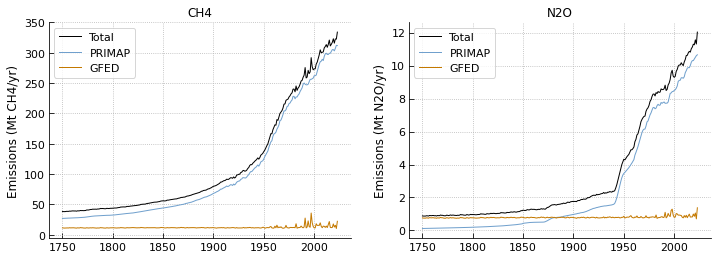

In [12]:
myplt.init_regular(2, col=2)

for ax, ((gas, unit), d0) in zip(myplt(), df.items()):
    d1 = dfin[(gas, 'PRIMAP CR v2.5.1*', f'Mt{gas}')]
    d2 = dfin[(gas, 'GFED v4.1*', f'Mt{gas}')]
    ax.plot(d0.index, d0, label='Total')
    ax.plot(d1.index, d1, label='PRIMAP')
    ax.plot(d2.index, d2, label='GFED')
    ax.legend()
    ax.set_title(gas)
    ax.set_ylabel(f'Emissions ({unit})')
    ax.grid()

In [13]:
dname = 'ClimateIndicator-2024/GHG-Emissions-Assessment__mod1'
k = 'emis_ch4_n2o'
df.to_hdf(outpath, key=f'{dname}/{k}')

with h5py.File(outpath, 'r+') as f1:
    grp = f1[f'{dname}/{k}']
    grp.attrs['description'] = 'Emissions of CH4 and N2O in 1750-2023'

## Inverted natural emissions of CH4 and N2O

In [14]:
gases = ['CH4', 'N2O']
unit_c = 'ppb'
unit_w = 'Mt'

w2cs = []
lifes = []

for gas in gases:
    w2cs.append(forcing.weight2conc(1, unit_w, gas, unit_c))
    lifes.append(forcing.ghgs[gas].lifetime)

w2cs = np.array(w2cs)
lifes = np.array(lifes)

In [15]:
lifes, w2cs

(array([ 11.8, 109. ]), array([0.35322459, 0.12873716]))

In [16]:
# Ensure that concentrations are given at 1-year intervals
time = df_conc_ghg.index.values
np.all(time[1:] - time[:-1] == 1)

True

In [17]:
# Anthropogenic total emissions
dname = 'ClimateIndicator-2024/GHG-Emissions-Assessment__mod1'
k = 'emis_ch4_n2o'
with pd.HDFStore(outpath, mode='r') as store:
    df_emis = store[f'{dname}/{k}']

In [19]:
lam = 200. # control parameter for smoothness and proximity

df_raw = {}
df_spl = {}

for gas, life, w2c in zip(gases, lifes, w2cs):
    # Observed concentrations
    d0 = df_conc_ghg[(gas, unit_c)]
    # Inverted emissions (natural + anthropogenic)
    d0_inv = (
        pd.Series(np.gradient(d0), index=d0.index) + d0 / life
    ) / w2c

    # Anthropogenic emissions
    d1 = df_emis[(gas, f'{unit_w} {gas}/yr')]
    # Inverted natural emissions
    d2 = d0_inv - d1
    spl = make_smoothing_spline(d2.index, d2, lam=lam)
    df_raw[gas] = d2
    df_spl[gas] = pd.Series(spl(d2.index), index=d2.index)

df_raw = pd.DataFrame(df_raw)
df_spl = pd.DataFrame(df_spl)

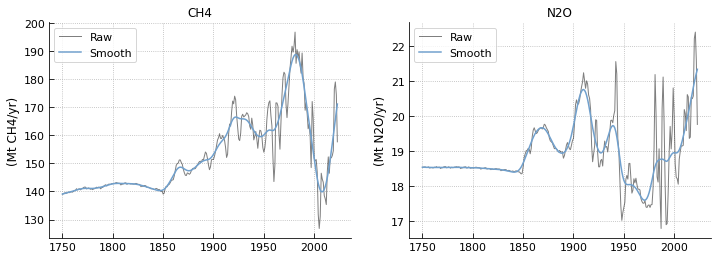

In [20]:
myplt.init_regular(2, col=2)

for ax, gas in zip(myplt(), gases):
    d0 = df_raw[gas].squeeze()
    d1 = df_spl[gas].squeeze()
    ax.plot(d0.index, d0, alpha=0.5, label='Raw')
    ax.plot(d1.index, d1, lw=1.5, label='Smooth')
    ax.legend()
    ax.set_ylabel(f'({unit_w} {gas}/yr)')
    ax.set_title(gas)
    ax.grid()

In [24]:
mi = pd.MultiIndex.from_tuples([
    (f'{gas} natural', f'{unit_w} {gas}/yr') for gas in df_spl
])
df = df_spl.copy()
df.columns = mi

In [28]:
dname = 'ClimateIndicator-2024/inverted_emissions'
k = 'emis_natural_ch4_n2o'
df.to_hdf(outpath, key=f'{dname}/{k}')

with h5py.File(outpath, mode='r+') as f1:
    grp = f1[f'{dname}/{k}']
    grp.attrs['description'] = 'Natural emissions of CH4 and N2O in 1750-2023'

### Time integration with the created emissions

In [29]:
with pd.HDFStore(outpath, mode='r') as store:
    dname = 'ClimateIndicator-2024/GHG-Emissions-Assessment__mod1'
    k = 'emis_ch4_n2o'
    df_emis = store[f'{dname}/{k}']

    dname = 'ClimateIndicator-2024/inverted_emissions'
    k = 'emis_natural_ch4_n2o'
    df_emis_nat = store[f'{dname}/{k}']

In [30]:
def func(t, y, xin, life, w2c):
    """Function to be passed on to the solver

    Parameters
    ----------
    t
        Time point in year
    y
        Gas concentration
    xin
        Interpolation function for gas emissions time series
    life
        Gas lifetime in year
    w2c
        Gas weight-to-concentration conversion factor

    Returns
    -------
        The time derivative of gas concentration
    """
    ydot = -y/life + xin(t) * w2c
    return ydot

In [45]:
# natural + anthropogenic
dfin = (
    df_emis
    +
    df_emis_nat
    .rename(
        lambda x: x.replace(' natural', ''),
        axis=1, level=0,
    )
)

In [46]:
dfin

,CH4,N2O
,Mt CH4/yr,Mt N2O/yr
1750,177.306461,19.412125
1751,177.290113,19.401241
1752,177.378137,19.397319
1753,177.567267,19.398340
1754,178.036993,19.416329
...,...,...
2019,482.879707,32.108747
2020,478.634329,32.216515
2021,488.344173,32.648715


In [47]:
gases = dfin.columns.get_level_values(0).tolist()

In [48]:
lifes = np.array([forcing.ghgs[gas].lifetime for gas in gases])
unit_w = 'Mt'
unit_c = 'ppb'
w2cs = np.array([
    forcing.weight2conc(1, unit_w, gas, unit_c)
    for gas in gases
])
lifes, w2cs

(array([ 11.8, 109. ]), array([0.35322459, 0.12873716]))

In [49]:
# Initial concentrations
y0 = df_conc_ghg.droplevel(1, axis=1).loc[1750, gases].values
y0

array([729.2, 270.1])

In [50]:
kw_interp = {'bounds_error': False, 'fill_value': 'extrapolate'}
time = dfin.index.values
interp = interp1d(time, dfin.T, **kw_interp)

In [53]:
# Concentrations from emissions by time integration
args = (interp, lifes, w2cs)
sol = solve_ivp(func, [time[0], time[-1]], y0, t_eval=time, args=args)

dfout = pd.DataFrame(sol.y.T, index=time, columns=gases)

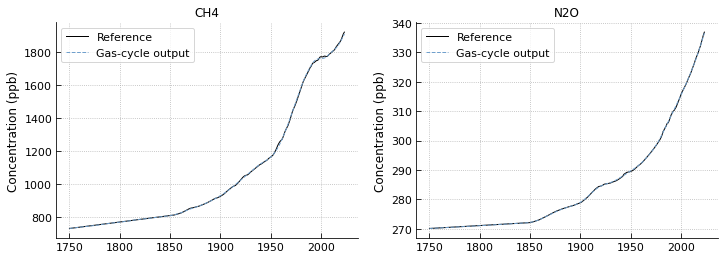

In [55]:
myplt.init_regular(2, col=2)

for ax, gas in zip(myplt(), gases):
    d0 = df_conc_ghg[(gas, unit_c)]
    d1 = dfout[gas]
    ax.plot(d0.index, d0, label='Reference')
    ax.plot(d1.index, d1, ls='--', label='Gas-cycle output')
    ax.legend()
    ax.set_ylabel(f'Concentration ({unit_c})')
    ax.set_title(gas)
    ax.grid()

## Inverted emissions of halogens

In [57]:
# Ensure that the first three columns are CO2, CH4, and N2O
df_conc_ghg.columns.get_level_values(0)[:3].tolist() == ['CO2', 'CH4', 'N2O']

True

In [58]:
# Drop CO2, CH4, and N2O
dfin = df_conc_ghg.iloc[:, 3:]

In [59]:
# Ensure that all the units are ppt
np.all(dfin.columns.get_level_values(1).values == 'ppt')

True

In [60]:
# Drop units level
dfin = dfin.droplevel(1, axis=1)

In [62]:
gases = dfin.columns.tolist()
len(gases)

49

In [63]:
unit_w = 'kt'
unit_c = 'ppt'

lifes = np.array([forcing.ghgs[gas].lifetime for gas in gases])
w2cs = np.array([
    forcing.weight2conc(1, unit_w, gas, unit_c)
    for gas in gases
])

In [64]:
# Ensure that input concentrations are given at 1-year intervals
time = dfin.index.values
np.all(time[1:] - time[:-1] == 1)

True

In [65]:
# Inverted emissions
yin = dfin.values
xinv = (np.gradient(yin, axis=0) + yin / lifes) / w2cs

In [67]:
mi = pd.MultiIndex.from_tuples([
    (gas, f'{unit_w} {gas}/yr') for gas in gases
])
df = pd.DataFrame(xinv, index=time, columns=mi)

In [68]:
dname = 'ClimateIndicator-2024/inverted_emissions'
k = 'emis_halogens'
df.to_hdf(outpath, key=f'{dname}/{k}')

with h5py.File(outpath, mode='r+') as f1:
    grp = f1[f'{dname}/{k}']
    grp.attrs['description'] = 'Emissions of halogens in 1750-2023'

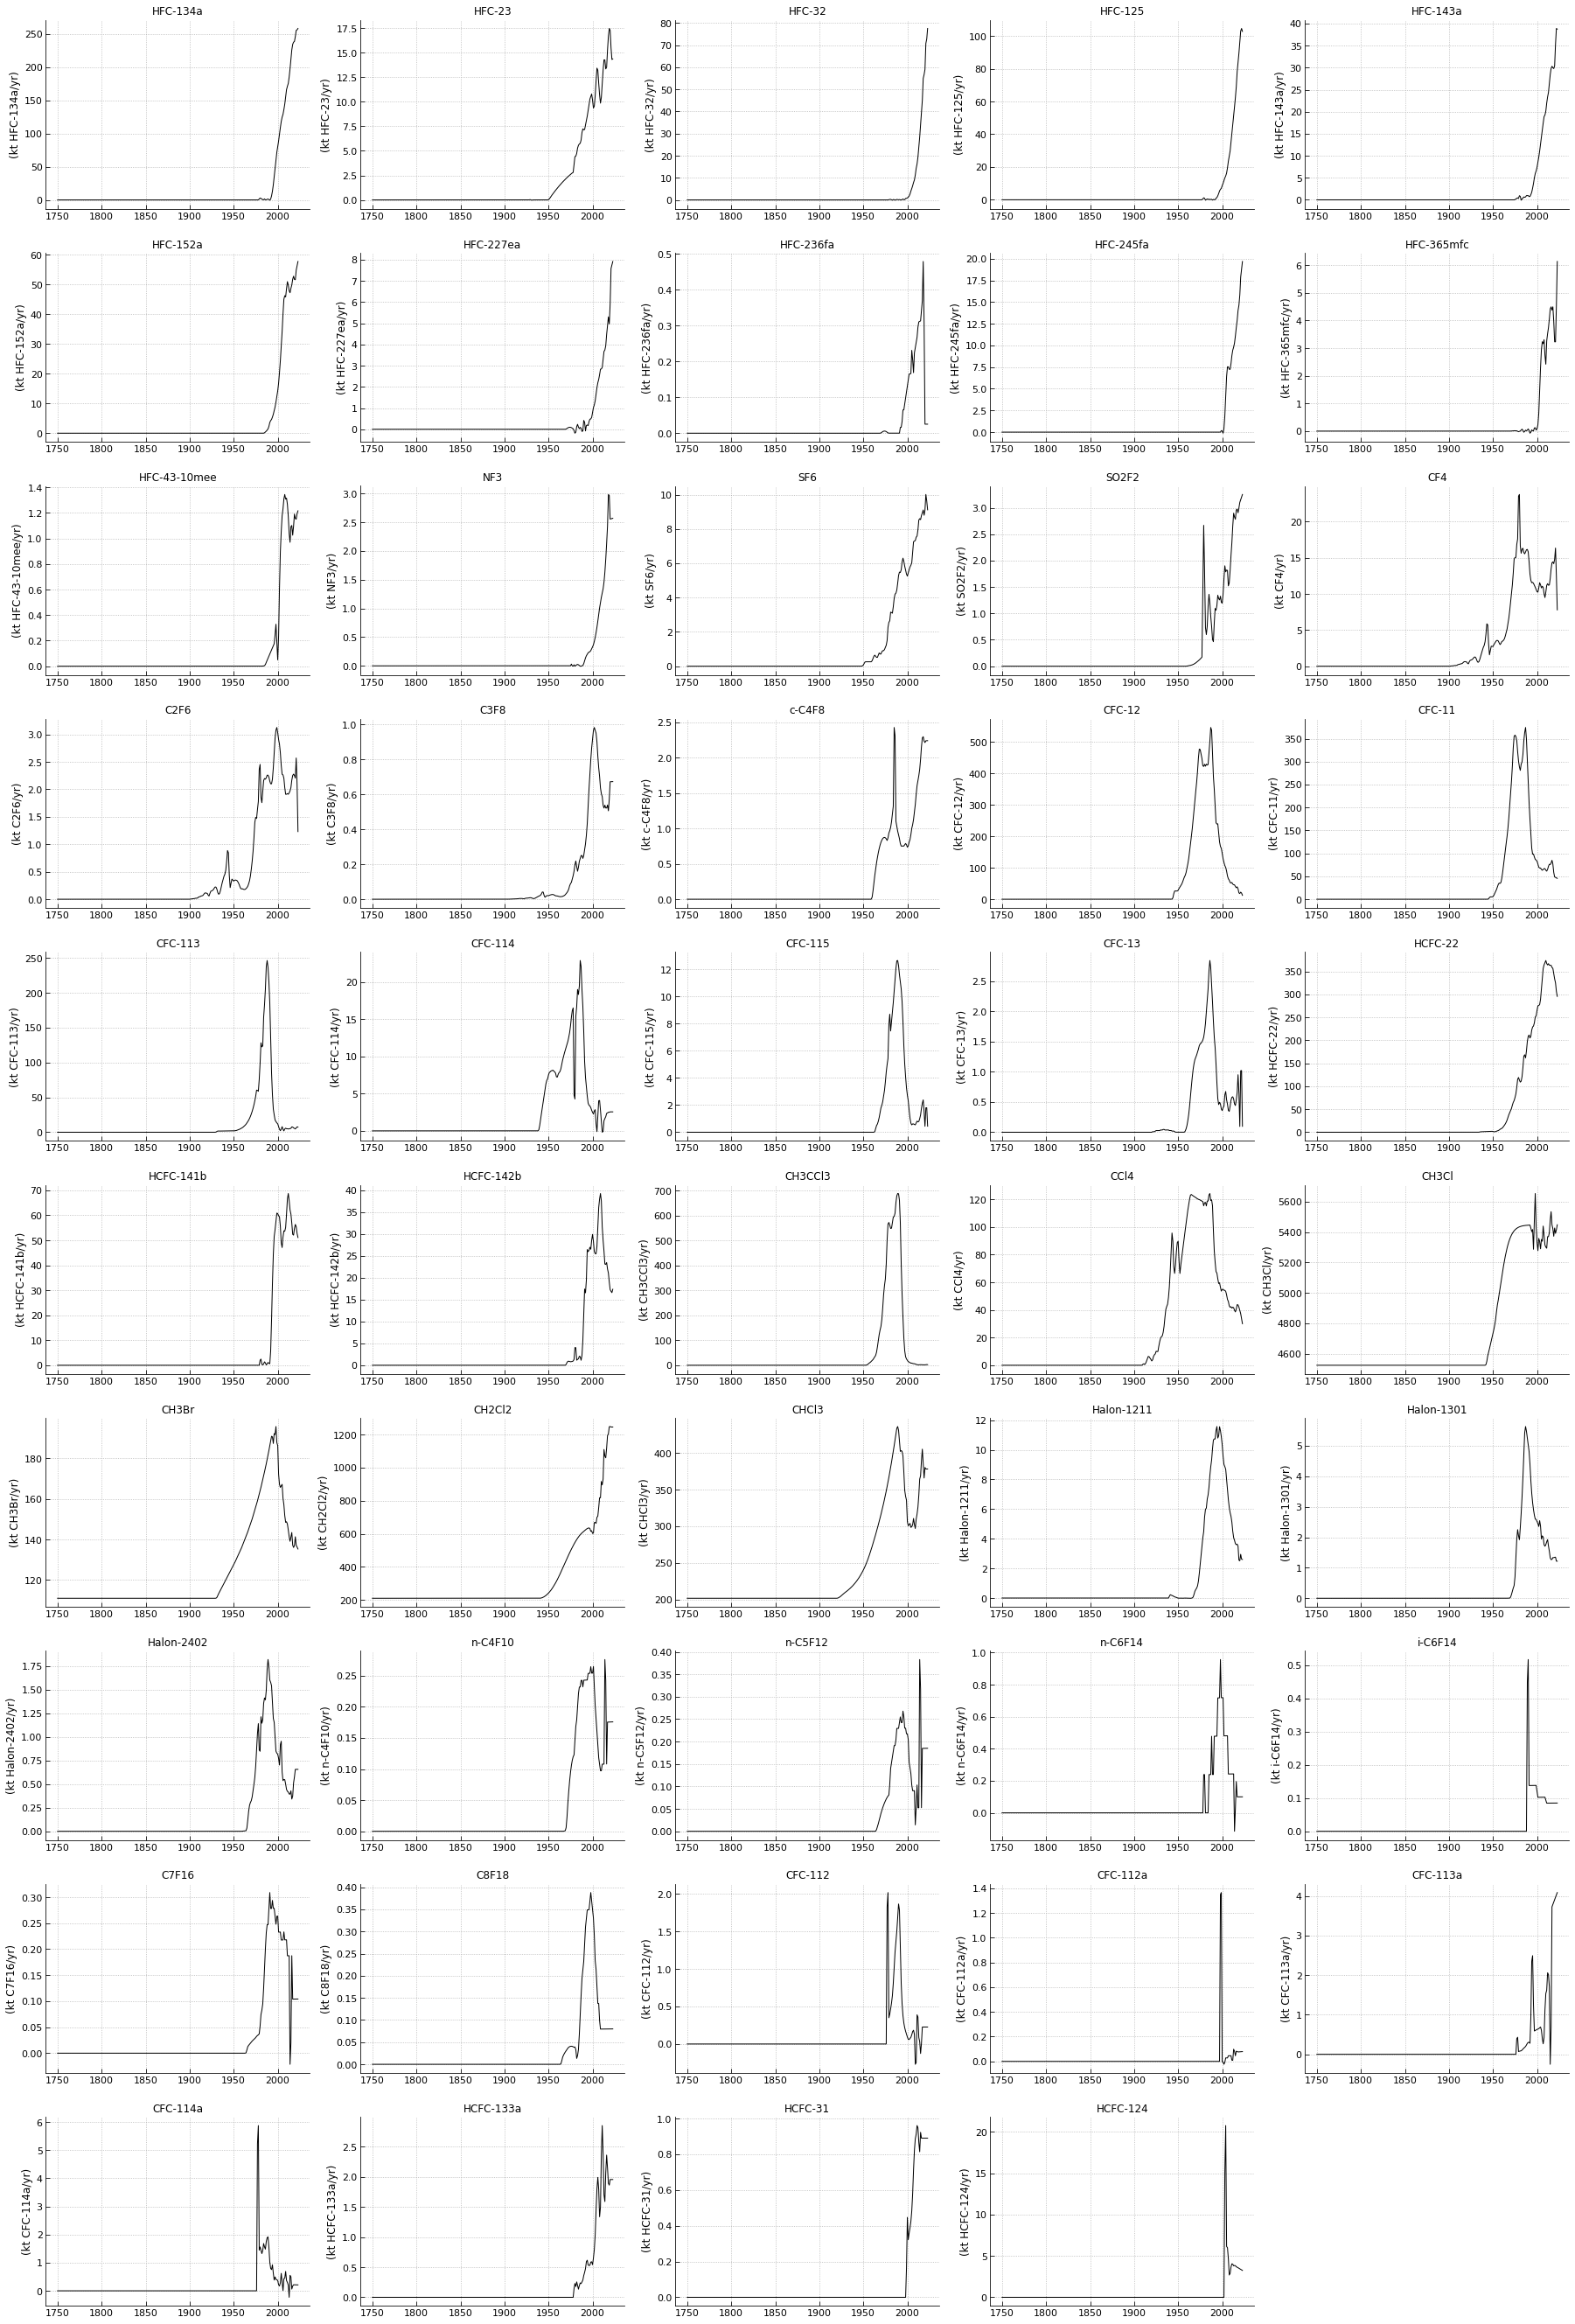

In [76]:
myplt.init_regular(len(gases), col=5)

for ax, ((gas, unit), d1) in zip(myplt(), df.items()):
    ax.plot(d1.index, d1)
    ax.set_title(gas)
    ax.set_ylabel(f'({unit})')
    ax.grid()

### Time integration with the inverted emissions

In [77]:
with pd.HDFStore(outpath, mode='r') as store:
    dname = 'ClimateIndicator-2024/inverted_emissions'
    k = 'emis_halogens'
    dfin = store[f'{dname}/{k}']

In [79]:
# Create an interpolation object for the inverted emissions
kw_interp = {'bounds_error': False, 'fill_value': 'extrapolate'}
time = dfin.index.values
interp = interp1d(time, dfin.T, **kw_interp)

In [82]:
dfin.columns.get_level_values(0).tolist() == gases

True

In [87]:
y0 = df_conc_ghg.droplevel(1, axis=1).loc[1750, gases].values

In [88]:
args = (interp, lifes, w2cs)
sol = solve_ivp(func, [time[0], time[-1]], y0, t_eval=time, args=args)

dfout = pd.DataFrame(sol.y.T, index=time, columns=gases)

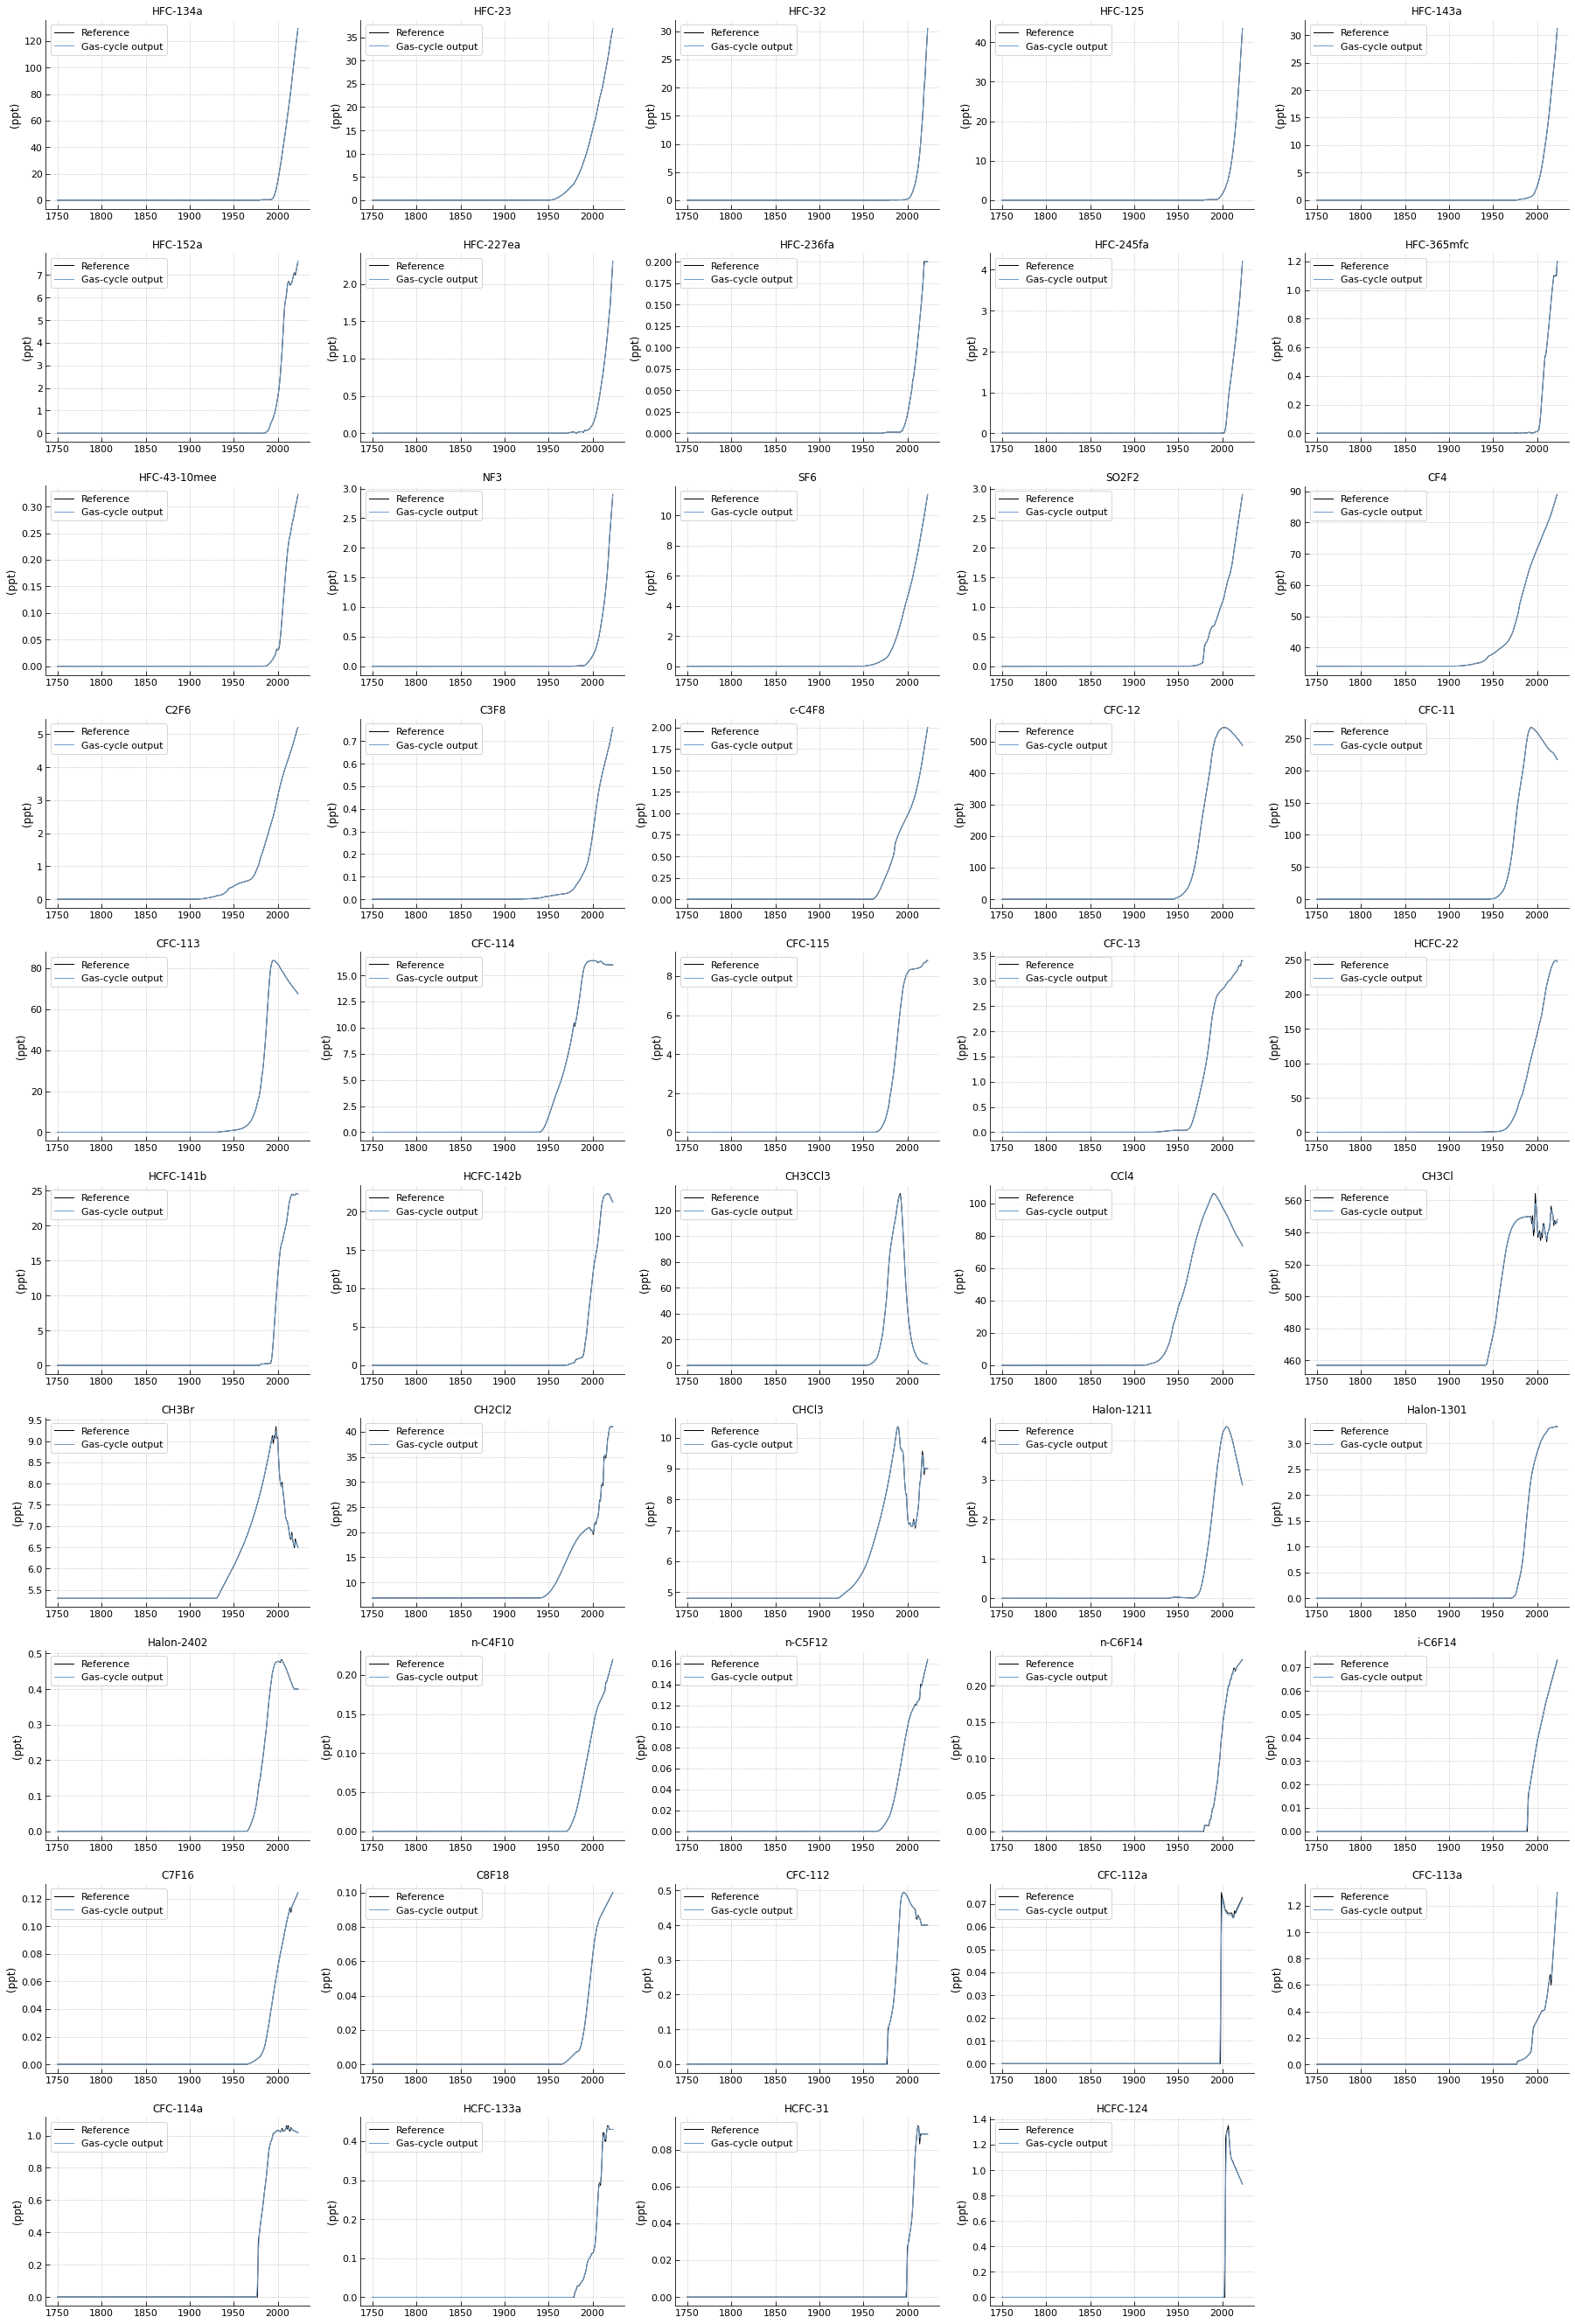

In [90]:
myplt.init_regular(len(gases), col=5)

for ax, gas in zip(myplt(), gases):
    d0 = df_conc_ghg[(gas, 'ppt')]
    d1 = dfout[gas]
    ax.plot(d0.index, d0, label='Reference')
    ax.plot(d1.index, d1, label='Gas-cycle output')
    ax.legend()
    ax.set_title(gas)
    ax.set_ylabel('(ppt)')
    ax.grid()

## Saved data

In [95]:
with h5py.File(outpath, 'r') as f1:
    for dname in [
        'ClimateIndicator-2024/GHG-Emissions-Assessment__mod1',
        'ClimateIndicator-2024/inverted_emissions',
        ]:
        print(dname)
        grp = f1[dname]
        grp.visititems(
            lambda name, obj:
            print('  {}: {}'.format(name, obj.attrs['description']))
            if isinstance(obj, h5py.Group) else None
        )

ClimateIndicator-2024/GHG-Emissions-Assessment__mod1
  emis_ch4_n2o: Emissions of CH4 and N2O in 1750-2023
ClimateIndicator-2024/inverted_emissions
  emis_halogens: Emissions of halogens in 1750-2023
  emis_natural_ch4_n2o: Natural emissions of CH4 and N2O in 1750-2023
